# Gather and format river flood observations

In [33]:
import sys
sys.path.append('../../..')  # Package root directory

import logging
import climada
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import copy
from climada.util import log_level
from climada.util.api_client import Client
from climada.util.constants import SYSTEM_DIR


logging.getLogger("climada").setLevel("WARNING")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [34]:
countries_to_filter_to = []  # Leave empty to use all
output_dir = Path('/Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/resources/observations/data')
emdat = pd.read_csv(Path(output_dir, 'raw', 'public_emdat_custom_request_2024-03-25_2f081933-bed3-41c7-9825-91371555fd41.csv'))
emdat_subset = emdat[
    (emdat['Disaster Type'] == "Flood") &
    (emdat["Total Damage ('000 US$)"] > 0)
]

# fix missing damage obs
emdat_subset[emdat_subset['Start Year'] == 2023]["Total Damage, Adjusted ('000 US$)"] = emdat_subset[emdat_subset['Start Year'] == 2023]["Total Damage ('000 US$)"]

if len(countries_to_filter_to) > 0:
    emdat_subset = emdat_subset.iloc[[i for i, c in enumerate(emdat_subset['Country']) if c in countries_to_filter_to]]
else:
    countries_to_filter_to = np.unique(emdat_subset[["Country"]])

emdat_subset

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
5,1903-0002-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,NaN,480000.0,15633778.0,3.070275,NaN,2003-07-01,2023-09-25
58,1920-0005-DFR,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,DFR,...,NaN,NaN,NaN,NaN,20000.0,292700.0,6.832935,NaN,2003-07-01,2023-09-25
77,1925-0007-DFR,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,DFR,...,NaN,NaN,NaN,NaN,19000.0,317789.0,5.978818,NaN,2003-07-01,2023-09-25
82,1926-0006-DFR,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,DFR,...,NaN,NaN,NaN,NaN,31000.0,512638.0,6.047147,NaN,2003-07-01,2023-09-25
88,1927-0005-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,NaN,230.0,3869.0,5.944653,NaN,2003-07-01,2023-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11824,2023-0581-ESP,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,ESP,...,NaN,NaN,NaN,NaN,370000.0,NaN,NaN,NaN,2023-09-05,2024-02-01
11850,2023-0663-BRA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,BRA,...,NaN,NaN,NaN,NaN,1200.0,NaN,NaN,NaN,2023-10-17,2024-01-29
11878,2023-0734-FRA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,FRA,...,NaN,NaN,NaN,NaN,1650000.0,NaN,NaN,NaN,2023-11-08,2024-02-01
11888,2023-0763-DOM,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,DOM,...,NaN,NaN,NaN,NaN,17500.0,NaN,NaN,NaN,2023-11-22,2023-12-19


There are lots of different flood types. Let's get some summary statistics:

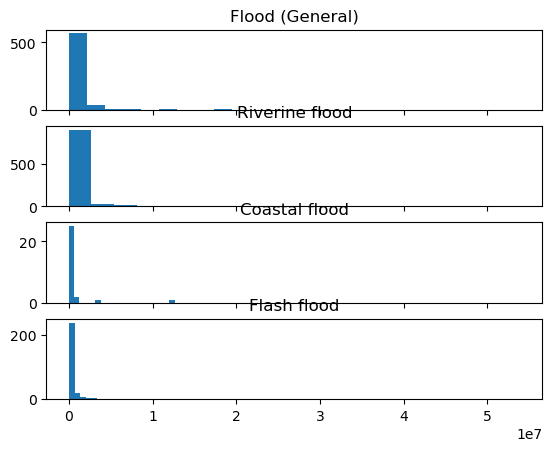

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

flood_types = emdat_subset['Disaster Subtype'].unique()

emdat_subset.groupby('Disaster Subtype').agg('count')['DisNo.']

fig, axs = plt.subplots(4, 1, sharex=True)
for ax, ftype in zip(axs.reshape(-1), flood_types):
    losses = emdat_subset[emdat_subset['Disaster Subtype'] == ftype]["Total Damage, Adjusted ('000 US$)"]
    losses = losses[losses > 0]
    ax.hist(losses, bins=20)
    ax.set_title(ftype)


We have to decide which of these flood types we're going to model.

Our event set is for river flood and we would hope that it can reproduce the spatial extent and losses of 'Riverine flood' and 'Flood (general)'. We'll run an analysis to compare losses and calibrated curves between the two.

It may be that 'Flood (general)' refers to larger floods that combine coastal/flash/riverine floods in one event. In this case we might find that it pushes us towards more stronger impact functions, but that's acceptable: this is the distribution of losses that we want to reproduce.

Excluding coastal flood makes sense: this can be considered a separate event, and the geographies do not align. We can make a similar argument for flash floods. 

In [36]:
emdat_subset = emdat_subset[emdat_subset['Disaster Subtype'].isin(['Flood (General)', 'Riverine flood'])]

Text(0.5, 1.0, 'Event Counts by Year')

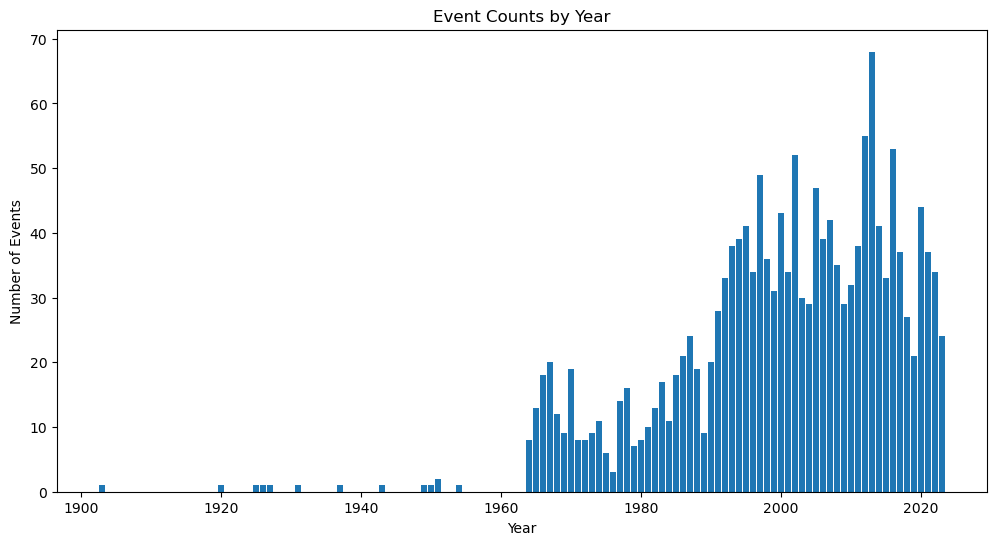

In [37]:
# Visualise event frequency
counts = emdat_subset[['Start Year', 'DisNo.']].drop_duplicates().groupby(['Start Year']).size().reset_index(name='count')

all_years = pd.DataFrame({'Start Year': range(counts['Start Year'].min(), counts['Start Year'].max() + 1)})
counts_filled = all_years.merge(counts, on='Start Year', how='left').fillna(0)
plt.figure(figsize=(12, 6))
plt.bar(counts_filled['Start Year'], counts_filled['count'])
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Event Counts by Year')

EM-DAT warns that data before the year 2000 is incomplete. There's clearly a trend here, with more complete data probably arriving sometime in the 1990s.

Let's set a cutoff of 1995. If we decide we need more events we can reconsider this decision, since it's likely that missing events are smaller events, which aren't so important for the calibration.

In [38]:
year_range = (1990, 2023)
emdat_subset = emdat_subset[
    (emdat_subset['Start Year'] >= year_range[0]) &
    (emdat_subset['Start Year'] <= year_range[1])
]

n_years = year_range[1] - year_range[0] + 1

In [56]:
from copy import deepcopy

rps = deepcopy(emdat_subset)[['Start Year', 'DisNo.', 'ISO', 'Disaster Subtype', "Total Damage, Adjusted ('000 US$)"]]
rps = rps.rename(columns={
    'Start Year': 'year',
    'DisNo.': 'emdat_eventcountry_id',
    'ISO': 'country',
    'Disaster Subtype': 'type',
    "Total Damage, Adjusted ('000 US$)": 'emdat_impact_scaled'
    })
rps['event_id'] = ['-'.join(s.split('-')[:-1]) for s in rps['emdat_eventcountry_id']]
rps = rps.sort_values(['country', 'year', 'emdat_impact_scaled'], ascending=[True, True, False])
print(rps)
rps.to_csv(Path(output_dir, 'FL_riverine_and_general_emdat_events.csv'), index=False)

       year emdat_eventcountry_id country             type  \
2915   1991         1991-0032-AFG     AFG   Riverine flood   
7551   2009         2009-0168-AFG     AFG   Riverine flood   
4686   2000         2000-0002-AGO     AGO   Riverine flood   
5507   2002         2002-0607-ALB     ALB   Riverine flood   
6149   2004         2004-0633-ALB     ALB   Riverine flood   
...     ...                   ...     ...              ...   
11291  2022         2022-0009-ZAF     ZAF  Flood (General)   
4210   1998         1998-0053-ZMB     ZMB  Flood (General)   
4702   2000         2000-0083-ZWE     ZWE   Riverine flood   
5023   2001         2001-0082-ZWE     ZWE  Flood (General)   
5866   2003         2003-0742-ZWE     ZWE   Riverine flood   

       emdat_impact_scaled   event_id  
2915              128931.0  1991-0032  
7551               27282.0  2009-0168  
4686               16995.0  2000-0002  
5507               28472.0  2002-0607  
6149                 268.0  2004-0633  
...            

In [62]:
def calc_rps(rps):
    rps = rps.rename(columns={'emdat_impact_scaled': 'impact'}).reset_index()
    n_years = np.max(rps['year']) - np.min(rps['year']) + 1
    rp_agg = rps[['country', 'year', 'impact']].groupby(['country', 'year']).agg('sum')
    rp_agg = rp_agg.sort_values(['country', 'impact'], ascending=[True, False])
    rp_agg['rank'] = rp_agg.groupby(['country']).cumcount() + 1
    rp_agg['rp'] = n_years / rp_agg['rank']
    rp_agg = rp_agg.reset_index()[['country', 'year', 'rp', 'impact']]
    return rp_agg

rp_agg = calc_rps(rps)
print(rp_agg)
rp_agg.to_csv(Path(output_dir, 'fl.csv'), index=False)

    country  year         rp    impact
0       AFG  1991  34.000000  128931.0
1       AFG  2009  17.000000   27282.0
2       AGO  2000  34.000000   16995.0
3       ALB  2002  34.000000   28472.0
4       ALB  2004  17.000000     268.0
..      ...   ...        ...       ...
829     ZAF  2008   2.833333    1718.0
830     ZMB  1998  34.000000   37163.0
831     ZWE  2003  34.000000  318175.0
832     ZWE  2000  17.000000  123894.0
833     ZWE  2001  11.333333    5950.0

[834 rows x 4 columns]


In [63]:
rps_general = rps[rps['type'] == 'Flood (General)']
rp_agg_general = calc_rps(rps_general)
print(rp_agg_general)
rp_agg_general.to_csv(Path(output_dir, 'fl_general.csv'), index=False)

    country  year         rp     impact
0       ARG  1998  34.000000  1974870.0
1       ARG  2000  17.000000   509852.0
2       ARG  1993  11.333333   186381.0
3       ARG  2020   8.500000    11308.0
4       ARM  1997  34.000000    14586.0
..      ...   ...        ...        ...
265     ZAF  2016  17.000000   219485.0
266     ZAF  2021  11.333333    81002.0
267     ZAF  2019   8.500000    57236.0
268     ZMB  1998  34.000000    37163.0
269     ZWE  2001  34.000000     5950.0

[270 rows x 4 columns]


In [ ]:
rps_riverine = rps[rps['type'] == 'Riverine flood']
rp_agg_riverine = calc_rps(rps_riverine)
print(rp_agg_riverine)
rp_riverine.to_csv(Path(output_dir, 'fl_riverine.csv'), index=False)